# Librerías

In [1]:
import os
import sys

import numpy as np
import pandas as pd 
import random
from glob import glob
import re
from scipy import interp  
from itertools import cycle


import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
%matplotlib inline
import cv2


from sklearn.metrics import SCORERS
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score 
from sklearn.datasets import make_classification 
import sklearn
from imblearn import under_sampling

import tensorflow as tf

from keras.utils import layer_utils, np_utils
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet, vgg16, nasnet  
from keras.models import Sequential, Model, load_model  
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D,Input
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers  
from keras import backend as K 

import pickle

Using TensorFlow backend.


# Importar imágenes

## Funciones

In [2]:
def open_images_names(directory):
    
    """
    **************************************************************
    
    Abre las imagenes de un directorio y las almacena en un array.
    Extrae el nombre del artista del path de la imagen.
    
    Input:
    *directory. Path en el que se encuentran las imágenes.
    Output:
    *np.array con la información de las imágenes
    *np.array con el nombre del artista.
    
    ***************************************************************
    """
    
    images_all = []
    images = glob(directory)
    i_ = 0
    
    for img in images:
        im = cv2.imread(img)
        images_all.append(np.asarray(im))
        i_ += 1
    
    artists = []
    for artist in images:
        art = re.sub("_", " ", (",").join(re.findall("\w+_", artist))[:-1])
        artists.append(art)

        
    return images_all, artists

In [3]:
def muestra(bd): 
    
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (8, 15) 
    
    num = random.randrange(len(images))
    print(f'Autor: {artists[num]}')
    print(f'Dimensión:{bd[num].shape}')
    print(f'Alto: {bd[num].shape[0]} px.')
    print(f'Ancho: {bd[num].shape[1]} px.')
    print(f'Profundidad: {bd[num].shape[2]} (RGB)')

    plt.imshow(cv2.cvtColor(bd[num], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## Proceso

Aplicando la función <code>open_images_names</code> obtendremos las imágenes a analizar junto a una lista con los nombres que se extraen del archivo, y solo habrá que pasarle la dirección del directorio donde están nuestras imagenes junto con <k>/**</k> para que extraiga todos los archivos que hay dentro.

In [4]:
images, artists = open_images_names("images/**")

Echaremos un primer vistazo al tamaño que tiene nuestros inputs.

In [5]:
print(f'Disponemos de un total de {len(images)} imagenes con {len(pd.unique(artists))} artistas diferentes, entre los que encontramos a {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]}, {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]} o {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]}.')

Disponemos de un total de 8683 imagenes con 50 artistas diferentes, entre los que encontramos a Paul Gauguin, Hieronymus Bosch o Camille Pissarro.


Con la función <code>muestra</code> podemos ver una imagen al azar de nuestra colección junto al nombre del artista y el tamaño. Cada vez que se ejecute saldrá una diferente.

Autor: Leonardo da Vinci
Dimensión:(232, 317, 3)
Alto: 232 px.
Ancho: 317 px.
Profundidad: 3 (RGB)


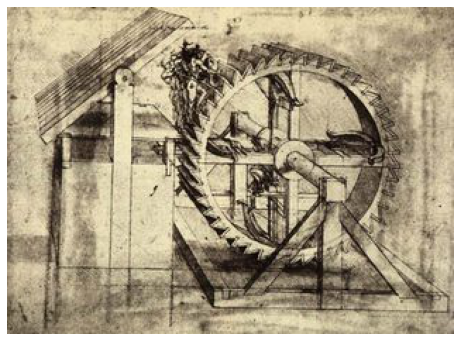

In [6]:
muestra(images)

# Corregir problemas de balanceo

## Funciones

In [7]:
def top_artists(df, y, num):
    
    """
    **************************************************************
    
    Divide la información en dos datasets diferentes usando la media
    del total de observaciones por categorías como separación.
    
    Input:
    df: dataframe a separar.
    y: variable dependiente.
    
    Output:
    *big_df: dataframe con las categorías con más observaciones.
    *small_df: dataframe con las categorías con menos observaciones.
    
    ***************************************************************
    """
    
    # Crea una lista con las etiquetas de categoría con más observaciones y otra con las que tienen menos.
    
    c = list(df['artist'].value_counts()[:num].index)
            
    # Crea dos dataframes agrupando según las categorías listadas en el paso anterior.
            
    big_df = []
    for i in c:
        big_df.extend(np.array(df[df[y] == i]))
    big_df = pd.DataFrame(big_df, columns = df.columns)

            
    return big_df

In [8]:
def visualice(df_big, df_small):
    
    """
    **************************************************************
    
    Muestra dos barplots con los artistas que se han separado.
    
    Input:
    df_big: dataframe con los artistas con más cuadros.
    df_small: dataframe con los artistas con menos cuadros.
    
    Output:
    * Barplots con ambas distribuciones
    
    ***************************************************************
    """

    print(f' El tamaño original es de {df_big.shape}. A partir de ahora trabajarás con {df_small.shape}.')
          
    fig = plt.figure(figsize=(15,5))

    fig.add_subplot(121)
    plt.title('Dataset original', fontsize=14)
    artists_plot1 = sns.countplot(df_big['artist'], palette="ch:.25")
    _=artists_plot1.set_xticklabels(artists_plot1.get_xticklabels(), rotation=65, horizontalalignment='right')
    fig.add_subplot(122)
    
    plt.title('Nueva selección', fontsize=14)
    artists_plot2 = sns.countplot(df_small['artist'], palette="ch:.25")
    _=artists_plot2.set_xticklabels(artists_plot2.get_xticklabels(), rotation=65, horizontalalignment='right')

In [9]:
def countplot_df(df, col):
    
    """
    **************************************************************
    Devuelve un gráfico de barras con los parámetros de visualización
    indicados
    Input:
    *df: dataframe del que extraer la información
    *col: columna que se quiere contar.
    **************************************************************
    
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    plot_df = sns.countplot(df[col], palette="ch:.25")
    _ = plot_df.set_xticklabels(plot_df.get_xticklabels(), rotation=65, horizontalalignment='right')

## Proceso

Generaremos una estructura de DataFrame para poder corregir los problemas de desbalanceo que hemos visto. Hacemos el cambio de estructura desde nuestras imágenes.

In [10]:
df = pd.DataFrame(images, columns = ['images'])

Añadimos la columna con los nombres de los artistas.

In [11]:
df['artist'] = artists

Echamos un vistazo al DataFrame creado y observamos la siguiente estructura:

In [12]:
df.head()

,images,artist
0,"[[[87, 99, 101], [43, 55, 57], [33, 42, 45], [...",Pieter Bruegel
1,"[[[84, 136, 149], [88, 140, 153], [87, 139, 15...",Francisco Goya
2,"[[[68, 80, 92], [63, 75, 87], [58, 70, 82], [5...",Paul Cezanne
3,"[[[122, 156, 186], [120, 154, 184], [109, 143,...",Vincent van Gogh
4,"[[[5, 6, 4], [0, 0, 0], [0, 2, 1], [0, 1, 0], ...",Titian


Podemos observar por ejemplo que disponemos de más de 800 cuadros de Van Gogh, frente a unos 50 de Cezanne. Hay diferentes estrategias que podemos seguir para corregir este problema:
* Empezaremos probando con una selección de artistas que tengan el número de obras más balanceadas.

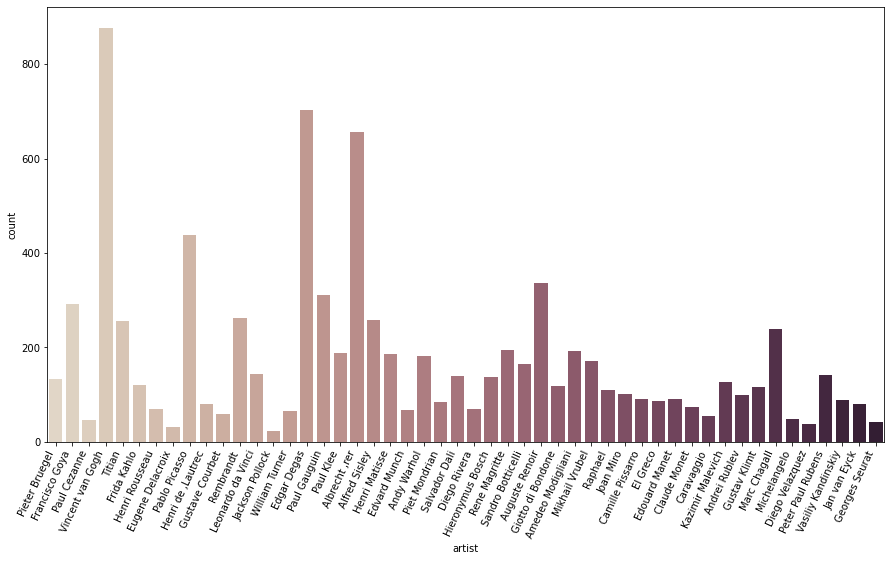

In [13]:
countplot_df(df, 'artist')

In [14]:
lst = []
for i in df['artist']:
    if i == "Albrecht ,rer":
        lst.append("Albrecht Dürer")
    else:
        lst.append(i)
df['artist'] = lst

In [15]:
version1 = top_artists(df, 'artist', 5)

Dataset original vs dataset con la selección.
 El tamaño original es de (8683, 2). A partir de ahora trabajarás con (3010, 2).


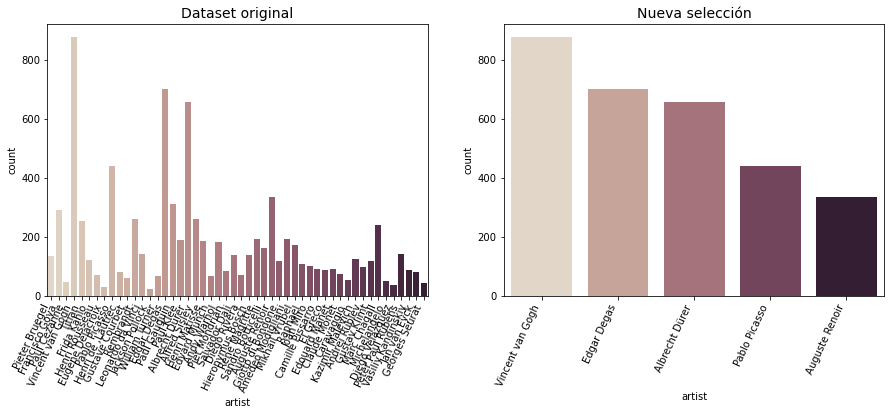

In [16]:
print("Dataset original vs dataset con la selección.")
visualice(df, version1)

In [17]:
version1.head()

,images,artist
0,"[[[122, 156, 186], [120, 154, 184], [109, 143,...",Vincent van Gogh
1,"[[[230, 218, 116], [217, 208, 104], [218, 212,...",Vincent van Gogh
2,"[[[175, 225, 231], [191, 240, 248], [180, 230,...",Vincent van Gogh
3,"[[[42, 147, 198], [82, 187, 238], [100, 208, 2...",Vincent van Gogh
4,"[[[37, 87, 105], [47, 99, 116], [97, 147, 169]...",Vincent van Gogh


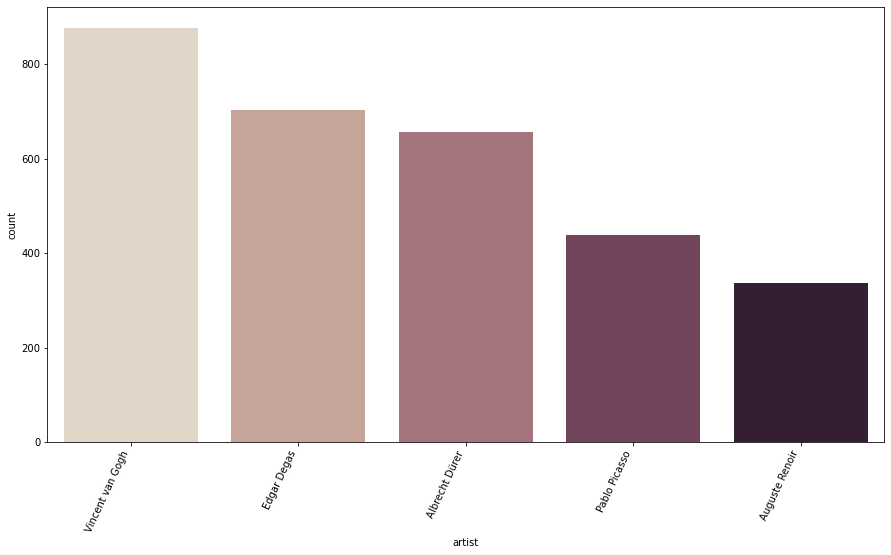

In [18]:
countplot_df(version1, 'artist')

# Separar train/test

Empezamos separando la *x* y la *y* de nuestro conjunto de datos. Extraeremos el número total de etiquetas y las convertiremos a valores numéricos adjudicándoles un número entre 0 y el número total de etiquetas con <code>LabelEncoder()</code>. Crearemos un diccionario para más tarde poder acceder a el valor de ese número.También crearemos una lista con los nombres de los artistas ordenados según el número del *encoder*.

In [19]:
images_v1=np.asarray(version1['images'])
artists =version1['artist']

In [20]:
num_classes = len(pd.unique(artists))

In [21]:
le=LabelEncoder()
le_artists = le.fit_transform(artists)
artists_dict = {}
for i in range(0, len(artists)):
    artists_dict[le_artists[i]]=artists[i]

In [22]:
artists_dict

{4: 'Vincent van Gogh',
 2: 'Edgar Degas',
 0: 'Albrecht Dürer',
 3: 'Pablo Picasso',
 1: 'Auguste Renoir'}

In [23]:
target_names = [artists_dict.get(i) for i in sorted(artists_dict)]

Separaremos en *train* y *test* dos veces para conseguir un conjunto de validación para el entreno.

In [24]:
x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(images_v1, le_artists, test_size=0.2, random_state=42)

In [25]:
x_train_original, x_val_original, y_train_original, y_val_original = train_test_split(x_train_original, y_train_original, test_size=0.2, random_state=42)

Convertimos nuestra variable dependiente en una serie de 0 y 1 con la función <code>.to_categorical()</code>

In [26]:
#Esto convierte a OneHotEncoding

y_train = np.array(np_utils.to_categorical(y_train_original, num_classes))
y_val = np_utils.to_categorical(y_val_original, num_classes)
y_test = np_utils.to_categorical(y_test_original, num_classes)

# Ajustar el tamaño de las imágenes

## Funciones

In [27]:
def resize_data(data):  
    
    """
    **************************************************************
    
    Ajusta el tamaño de la imagen para su estandarización.
    
    ***************************************************************
    """
    
        
    res_data = []
    for i in range(len(data)):
        res = cv2.resize(data[i], dim, interpolation=cv2.INTER_LINEAR)
        res_data.append(res)

    return res_data

In [28]:
def compara_muestras(db1, db2):
        
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    
    num = random.randrange(len(db1))
    
    print(f'Autor: {artists[num]}')
    print(f'Dimensión original:{db1[num].shape}')
    print(f'Dimensión ajustada:{db2[num].shape}')
    print(f'Filas originales: {db1[num].shape[0]}')
    print(f'Filas ajustadas: {db2[num].shape[0]}')
    print(f'Columnas originales: {db1[num].shape[1]}')
    print(f'Columnas ajustadas: {db2[num].shape[1]}')
    print(f'Profundidad: {db1[num].shape[2]}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Imagen original vs imagen ajustada')

    ax1.imshow(cv2.cvtColor(db1[num], cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax1.set_title("Imagen original")
    ax2.imshow(cv2.cvtColor(db2[num], cv2.COLOR_BGR2RGB))
    ax2.axis('off')
    ax2.set_title("Imagen ajustada")
    plt.show()

## Proceso

Las imágenes que forman nuestra colección tienen diferentes tamaños; deberemos establecer un tamaño común para poder entrenar nuestro algoritmo.

In [29]:
dim = (250, 250)

In [30]:
x_train = np.asarray(resize_data(x_train_original))

In [31]:
x_test = np.asarray(resize_data(x_test_original))

In [32]:
x_val = np.asarray(resize_data(x_val_original))

Comparamos la imagen original con el ajuste.

Autor: Vincent van Gogh
Dimensión original:(242, 300, 3)
Dimensión ajustada:(250, 250, 3)
Filas originales: 242
Filas ajustadas: 250
Columnas originales: 300
Columnas ajustadas: 250
Profundidad: 3


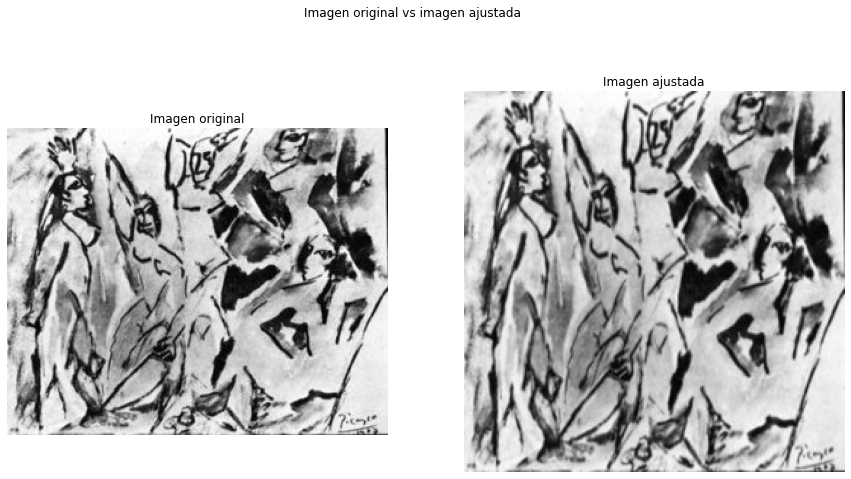

In [33]:
compara_muestras(x_train_original, x_train)

# DataAugmentation

Ahora estableceremos los parámetros para la creación de nuevas imagenes a partir de modificaciones de la original. Estas variaciones permiten aprovechar cada parte de la imagen para encontrar los patrones, lo cual es muy útil cuando tenemos pocas imágenes. Podemos realizar las siguientes modificaciones:
* **rotation_range**: Indica el numero maximo de grados que la imagen se puede inclinar.
* **width shift range, height shift range**: cambia de orientación los pixeles de algunas partes de la imagen.
* **shear_range**: Modifica algunas partes de la imagen modificando la orientación.
* **zoom_range**: Aplica un acercamiento a la imagen.
* **horizontal_flip**: Cambia la orientación de la imagen.
* **fill_mode**: Cuando a la imagen se le aplica una rotación cambia su aspecto, para mantener el mismo aspecto se tienen que rellenar los pixeles faltantes, con la opción nearest los pixeles cercanos se repiten para rellenar las areas faltantes.

In [34]:
#Este está creado para la visualización
train_generator_viz = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')

#Este es el que pasaremos al modelo con el rescalado de valores
train_generator = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        rescale = 1.0/255)

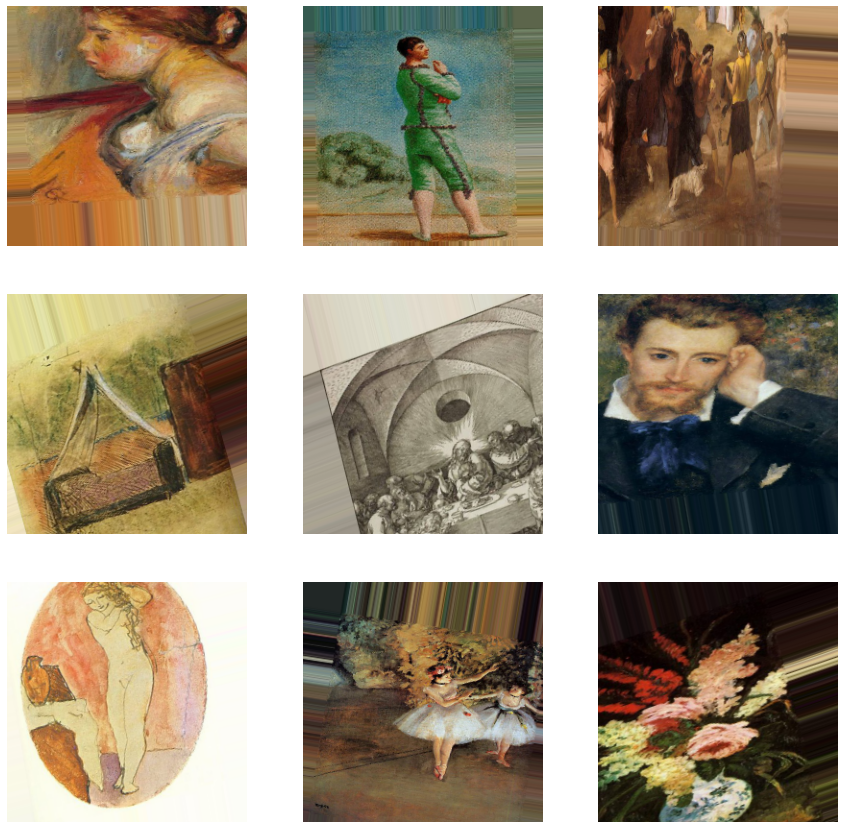

In [35]:
fig = plt.figure(figsize=(15,15))

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = train_generator_viz.flow(x_train).next()
    image = batch[0].astype('uint8')
    plt.axis('Off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.show()

# Empecemos

## Algunas consideraciones previas

Antes de comenzar a probar modelos determinaremos nuestros objetivos en los resultados. Para ello definimos las métricas que nos indicarán si nuestro modelo está haciendo bien el trabajo, empezando por los indicadores:


**Métricas de evaluación del modelo**:

* **loss**: Por lo general, con las redes neuronales, buscamos minimizar el error. Como tal, la función objetivo a menudo se denomina función de costo o función de pérdida y el valor calculado por la función de pérdida. Compara y mide cuan bueno/malo fue el resultado de la predicción en relación con el resultado correcto. Cuanto más proximo a 0 sea, mejor, queremos que la divergencia entre el valor estima y el esperado sea lo más pequeña posible.

* **mse**: El *error cuadrático medio* (median standard error)es una función de coste. Se pueden utilizar métodos estadísticos formales para determinar la confianza del modelo entrenado. 

* **acurracy**: La exactitud mide el porcentaje de casos en los que el modelo ha acertado. Es una medida que se debe interpretar con cuidado, ya que puede dar buenos resultados sin un buen modelo cuando las clases están desbalanceadas. Se mide dividiendo la suma de los verdaderos positivos y los verdaderos negativos entre la suma de los verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.
* **precision**: La precisión mide la **calidad** del modelo. Es el resultado de dividir los verdaderos positivos entre la suma de los verdaderos positivos y los falsos positivos.
* **recall**: La exhaustividad nos aporta información sobre la **cantidad** de elementos que es capaz de identificar. Es el número de resultante de dividir los verdaderos positivos entre la suma de los verdaderos positivos y los falsos negativos.
* **f1**: El Valor-F combina las medidas de precisión y recall en un solo valor, siendo el resultado de multiplicar por dos el producto de la precision y el recall entre la suma de los mismos.

## Funciones

In [36]:
def conf_matrix(num_classes, model_pred):
    
    """
    **************************************************************
    
    Crea una matriz de confusión del modelo.

    ***************************************************************
    """
    
    #Creamos la matriz de confusión
    model_cm = confusion_matrix(np.argmax(y_test, axis=1), model_pred)

    # Visualizamos la matriz de confusión
    model_df_cm = pd.DataFrame(model_cm, range(num_classes), range(num_classes))  
    plt.figure(figsize = (20,14))  
    sns.set(font_scale=1.4) #for label size  
    sns.heatmap(model_df_cm, annot=True, annot_kws={"size": 12}, xticklabels=target_names, yticklabels=target_names)  
    plt.show() 

In [37]:
def plot_train_vs_val (model):
    
    """
    **************************************************************
    
    Visualiza en forma de gráfico las curvas del accuracy y del loss
    entre el train y el test.

    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (8, 6) 
    
    plt.figure(0)  
    plt.plot(model.history['acc'],'r')  
    plt.plot(model.history['val_acc'],'g')  
    plt.xticks(np.arange(0, 50, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Accuracy")  
    plt.title("Training Accuracy vs Validation Accuracy")  
    plt.legend(['train','validation'])

    plt.figure(1)  
    plt.plot(model.history['loss'],'r')  
    plt.plot(model.history['val_loss'],'g')  
    plt.xticks(np.arange(0, 50, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Loss")  
    plt.title("Training Loss vs Validation Loss")  
    plt.legend(['train','validation'])

    plt.show()

In [38]:
def test_img(model_predicted):
    
    """
    **************************************************************
    
    Devuelve una imagen con el resultado del modelo de predicción
    indicado.
    
    Input:
    -model_predicted: resultados del modelo con el test.
    
    Output:
    -Imagen con la predicción.
    
    
    ***************************************************************
    """
    
    
    #Genera la elección aleatoria de la imagen
    num = random.randrange(len(y_test))
    
    #Imprime la imagenx
    plt.imshow(cv2.cvtColor(x_test_original[num], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    #Busca en el diccionario para devolver el nombre del artista y no la etiqueta
    real= artists_dict.get(np.argmax(y_test[num]))
    predicted= artists_dict.get(model_predicted[num])
    
    #Muestra la etiqueta real y la predicha.
    print(f'Artista real      :   {real}')  
    print(f'Artista predicho  :   {predicted}') 

In [39]:
def guardar(model, model_name):
    
    """
    **************************************************************
    
    Guarda el modelo en formato h5 y su histórico en txt.
    
    Input:
    -model: modelo a guardar
    
    Output:
    -Imagen con la predicción
    
    
    ***************************************************************
    """
    #Modelo
    model.save(model_name+'.h5')
    #Histórico
    with open(model_name + '.txt', 'wb') as file_pi:  
        pickle.dump(model.history, file_pi)

In [40]:
K.set_image_data_format('channels_last')  

In [41]:
K.set_learning_phase(1) 

## Hiperparamétros

Para las funciones de <code>callback</code> usaremos:

* **EarlyStopping**: Para el entreno cuando la función de coste no mejora en un número dado de epochs reduciendo el **overfitting**. Para ello le indicamos <code>verbose</code> en 1, para saber el epoch en el que el modelo se ha parado. Con <code>patience</code> le indicamos cuantos epochs tienen que pasar para que el entrenamiento pare y con <code>min_delta</code> establecemos un incremento específico de la mejora para el error cuadrático.


* **ReduceLROnPlateau**: Si el entrenamiento no mejora tras unos epochs específicos, reduce el valor de learning rate del modelo, lo que normalmente supone una mejora del entrenamiento.

In [42]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
callbacks = [early_stop, reduce_lr] 

Usaremos una técnica llamada gradient descent.  Esta técnica va cambiando los pesos en pequeños incrementos con la ayuda del cálculo de la derivada (o gradiente) de la función de loss, cosa que nos permite ver en qué dirección “descender” hacia el mínimo global; esto lo va haciendo en general en lotes de datos (batches) en las sucesivas iteraciones (epochs) del conjunto de todos los datos que le pasamos a la red en cada iteración

* **Batch**: Con el *bach* definimos el número de muestras para trabajar antes de actualizar los paramétros internos del modelo. Las predicciones se comparan con las variables de salidad esperadas y se calcula el error. A partir de este error el algoritmo se actualiza para mejorarse.

    * **Batch Gradient Descent**. Cuando el tamaño del bach es igual que el del conjunto de entrenamiento.
    * **Stochastic Gradient Descent**. Cuando el tamaño del bach es igual a 1.
    * **Mini-Batch Gradient Descent**. Cuando el tamaño del bach está entre uno y el tamaño del conjunto de entrenamient, los más frecuentes en tutoriales son de  32, 64 y 128.
    
    
* **Epoch**: Se trata de un hiperparámetro que define el número de veces que el algoritmo de aprendizaje funcionará sobre el conjunto de datos de entrenamiento. Cada muestra del conjunto de datos de entrenamiento tiene la "oportunidad" de actualizar los parámetros internos del modelo. Puede estar compuesto por uno o más *batches*. El número de *epochs* suele ser grande, lo que permite que el algoritmo se ejecute hasta que el error del modelo se minimice lo suficiente.

In [43]:
epochs = 100
batch_size = 32

Definimos nuestra función de pérdida en <code>loss</code> entre las opciones:
* <code>'categorical_crossentropy'</code> : Calcula la pérdida de crossentropy entre los artistas y las predicciones. Se usa cuando hay dos o más etiquetas. Necesita de una representación <code>OneHotEncoding</code>.
* <code>'sparse_categorical_crossentropy'</code> : Calcula la pérdida de crossentropy entre los artistas y las predicciones. Se usa cuando hay dos o más etiquetas. Necesita de una representación <code>LabelEncoder</code>.

Para nuestro <code>optimizer</code> usaremos:
* <code>'Adam'</code>: implementa el algoritmo Adam. Se trata de un método de descenso de gradiente estocástico que se basa en la estimación adaptativa. Se trara de un método computacionalmente eficiente y con pocos requisitos de memoria y adecuado para problemas con grandes cantidades de datos/parámetros.

En cuanto a nuestras métricas, en <code>metrics</code> nos centraremos, como hemos comentado más arriba, en el accuracy y el error cuadrático.

# Red Neuronal

Una red neuronal es un grupo interconectado de nodos de forma similar a las neuronas de un cerebro. Una red neuronal simple se caracteriza por tener un número de entradas y un número de salidas. Cada entrada tendrá un peso e influirá en la salida de la neurona.

## Creamos la red

Empezaremos definiendo una red neuronal simple y junto con ella, algunos conceptos que se irán repitiendo a medida que vayamos viendo diferentes modelos:
* **Sequential()**: Agrupa de forma lineal las capas del modelo proporcionando características de capacitación e inferencia al modelo.
* **Flatten**: Convierte la matriz de entrada en un array de 1 dimensión (plano).
* **Dense**: Añade una capa oculta a la red neuronal.

**Función de activación ReLu**: Transforma los valores introducidos anulando los valores negativos y dejando los positivos tal y como entran. La ventaja de usar la función ReLU radica en que no posee regiones de saturación dado que tiene un comportamiento lineal para entradas positivas, lo que evita precisamente este "estancamiento" durante el entrenamiento.

**Función de salida SoftMax**: Cuando el entrenamiento es multietiqueta pero no multiclase, tenemos muchos artistas diferentes pero todos pintores. Asigna probabilidades decimales a cada clase en un caso de clases múltiples. Esas probabilidades decimales deben sumar 1.0. Esta restricción adicional permite que el entrenamiento converja más rápido.

Ahora ya solo queda entrenarla, para lo cual le indicamos nuestras imágenes, los pintores y los parámetros que hemos establecido antes. Usaremos la función <code>.fit_generator()</code> en lugar de <code>.fit()</code> dado que nos permite llamar a las características que hemos establecido antes con <code>ImageDataGenerator</code> para aumentar el número de imágenes a analizar con pequeñas modificaciones.

Este modelo ha necesitado 28 *epochs* de los 100 establecidos al principio, al no pararse por la función de <code>EarlyStopping</code>. Podríamos concluir que para llegar a los resultados óptimos deberíamos aumentar este valor. Cada uno ha tardado 16 segundos, lo que ha hecho que el modelo tarde algo más de **13 minutos** en total.

La función <code>.evaluate_generator()</code> nos permite las métricas *loss*, *accuracy* y *mse* que obtiene el modelo. Con estos primeros datos podemos ver como el coportamiento final de todos los parámetros es más que aceptable para una red neuronal simple. Tenemos un *loss* de 19,37, lo que indica un coste de computación alto, la *accuracy* no está mal tampoco, próximo a la mitad de los casos acierta y vemos que el *mse* también es una cifrá relativamente baja.

Una vez entrenado el modelo procedemos a ver los resultados que obtenemos con el conjunto de datos de test. Para ello empezaremos observando la matriz de confusión donde se pueden apreciar las etiquetas reales frente a las predichas. Podemos observar que el comportamiento y la capacidad de predicción no es del todo mala.

# IncepcionResNetV2 con ImageNet

En este caso usaremos la red pre-entrenada *IncepcionResNetV2* con  *ImageNet*. Intentaremos ajustarla para ver que resultados nos da con nuestro dataset. Usaremos métodos de *fine-tuning* para ahorrar en nuestros recursos de computación y evitarnos la mayor parte del tiempo de entreno. Le añadimos algunas capas extras.

<img src = "inceptionresnetv2.png" width="1000" >

## Creamos la red

In [44]:
def build_IncepcionImagenet_model(layers):
    imagenet_model = InceptionResNetV2(weights='imagenet', include_top=False)
    x = imagenet_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x) 
    imagenet_model = Model(input=imagenet_model.input, output=predictions)
    for layer in imagenet_model.layers[:layers]:
        layer.trainable = False
    
    return imagenet_model

In [45]:
imagenet_model = build_IncepcionImagenet_model(700)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [46]:
imagenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

In [47]:
#imagenet_model.summary()

## Entrenamos el modelo

In [48]:
imagenet = imagenet_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size) ,
    steps_per_epoch=len(x_train)// batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks = callbacks,
    shuffle=True)

Epoch 1/100
60/60 [==============================] - 388s 6s/step - loss: 0.7698 - acc: 0.7423 - mse: 0.0737 - val_loss: 0.5011 - val_acc: 0.8340 - val_mse: 0.0518
Epoch 2/100
60/60 [==============================] - 381s 6s/step - loss: 0.4080 - acc: 0.8548 - mse: 0.0419 - val_loss: 0.4813 - val_acc: 0.8506 - val_mse: 0.0454
Epoch 3/100
60/60 [==============================] - 364s 6s/step - loss: 0.3125 - acc: 0.8970 - mse: 0.0307 - val_loss: 0.3797 - val_acc: 0.8755 - val_mse: 0.0379
Epoch 4/100
60/60 [==============================] - 372s 6s/step - loss: 0.2469 - acc: 0.9129 - mse: 0.0254 - val_loss: 0.3921 - val_acc: 0.8651 - val_mse: 0.0398
Epoch 5/100
60/60 [==============================] - 360s 6s/step - loss: 0.2447 - acc: 0.9155 - mse: 0.0253 - val_loss: 0.3914 - val_acc: 0.8797 - val_mse: 0.0383
Epoch 6/100
60/60 [==============================] - 359s 6s/step - loss: 0.2114 - acc: 0.9303 - mse: 0.0209 - val_loss: 0.3649 - val_acc: 0.8734 - val_mse: 0.0368
Epoch 7/100
60/6

## Evaluamos el modelo

In [49]:
imagenet_evaluation = imagenet_model.evaluate_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), verbose=1) 
imagenet_evaluation

61/61 [==============================] - 268s 4s/step


[0.004664307460188866, 0.9813084006309509, 0.005200735293328762]

En el primer gráfico se presenta la Accuracy obtenida en cada epoch, tanto para los datos de entrenamiento como los de test. En el segundo gráfico vemos la evolución en cada epoch de la Loss para los dos conjuntos de datos.

Si miramos el comportamiento general de estas gráficas vemos que son el característico cuando un modelo presenta Overfitting. Por un lado la Accuracy de los datos de entrenamiento aumenta linealmente con las epochs, hasta alcanzar casi el 85%, mientras que la Accuracy de los datos de validación se detiene alrededor del 80% y a partir de aquí se mantiene constante a lo largo de las epochs. La Loss de los datos de validación alcanza su mínimo después de algunos epochs y luego se mantiene, mientras que la Loss de los datos de entrenamiento disminuye linealmente hasta llegar a casi 0,4 donde se mantiene.

A pesar de todo, los resultados no son tan malos, si consideramos que tenemos muy pocas imágenes. Si evaluamos el modelo con los datos de Test, nos lo confirma, obtenemos que este modelo acierta alrededor del 79 %:

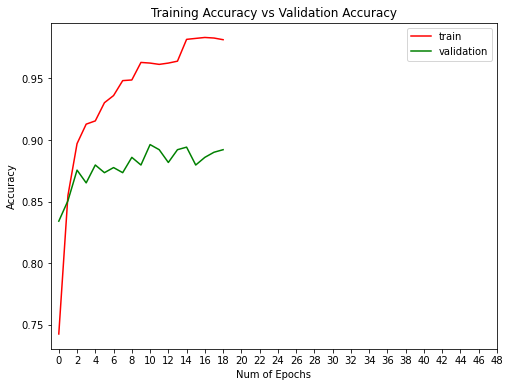

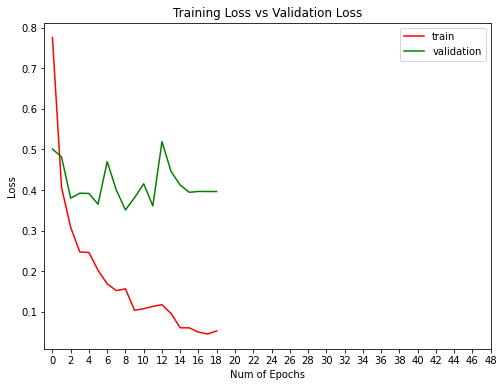

In [51]:
plot_train_vs_val(imagenet)

## Predicción del modelo

In [52]:
imagenet_pred = imagenet_model.predict(x_test, batch_size=batch_size, verbose=1)  
imagenet_predicted = np.argmax(imagenet_pred, axis=1) 

602/602 [==============================] - 91s 151ms/step


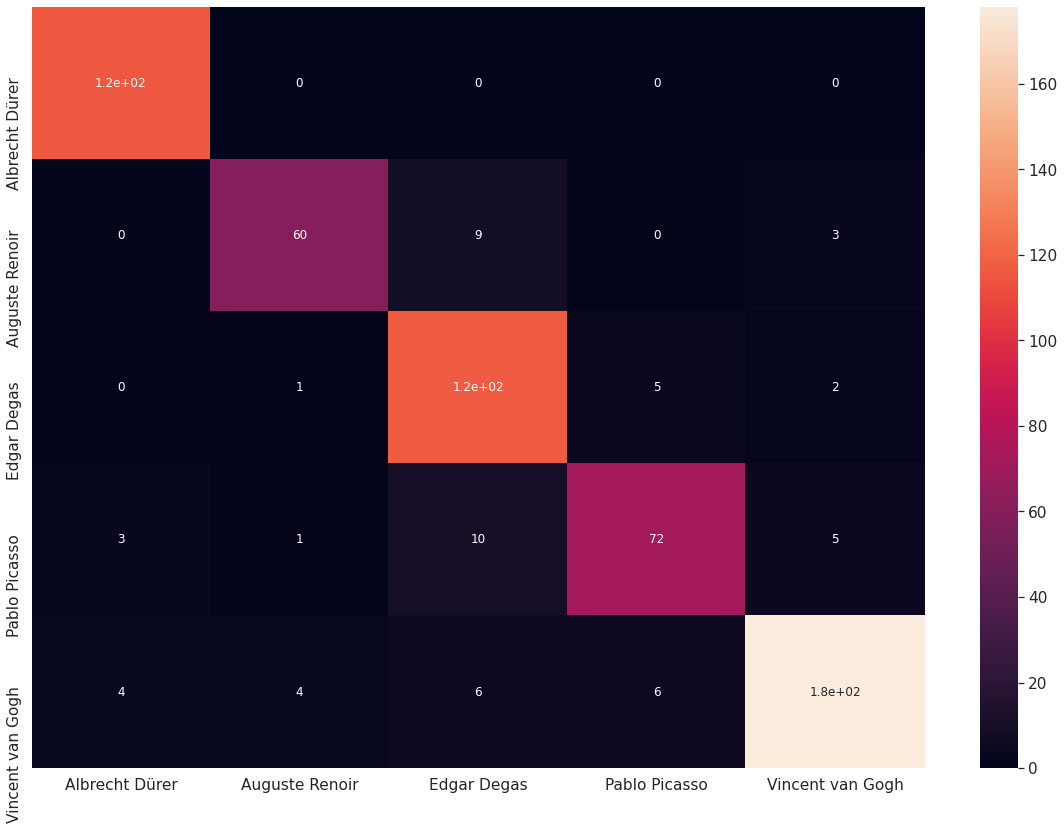

In [53]:
conf_matrix (num_classes, imagenet_predicted)

In [54]:
imagenet_report = classification_report(np.argmax(y_test, axis=1), imagenet_predicted, target_names=target_names)  
print(imagenet_report)

                  precision    recall  f1-score   support

  Albrecht Dürer       0.94      1.00      0.97       116
  Auguste Renoir       0.91      0.83      0.87        72
     Edgar Degas       0.82      0.94      0.88       125
   Pablo Picasso       0.87      0.79      0.83        91
Vincent van Gogh       0.95      0.90      0.92       198

        accuracy                           0.90       602
       macro avg       0.90      0.89      0.89       602
    weighted avg       0.90      0.90      0.90       602



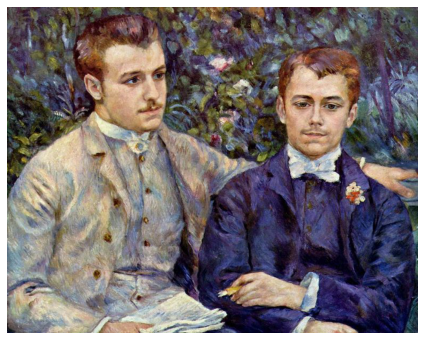

Artista real      :   Auguste Renoir
Artista predicho  :   Auguste Renoir


In [56]:
test_img(imagenet_predicted)

## Conclusiones

## Guardar los resultados

In [63]:
guardar(imagenet_model, "imagenet_model")